In [1]:
import matplotlib.pyplot as plt
import numpy as np
from brian2.only import *
import seaborn as sns
import deepdish as dd
from scipy.stats import bootstrap

import plot_utils as pu
from digest import conds, get_digest_output, get_voltages
import isi_indexing as ii
from readout import load_results
from digest import get_voltage_histograms

import conf.isi5_mouse as cfg

In [2]:
labelling = {
    'pspike': 'Spike probability',
    'Depression': '$V_{STD}$ (mV)',
    'Threshold': '$V_{TA}$ (mV)',
    'Synapses': '$V_{syn}$ (mV)',
    'Reset': '$V_{reset}$ (mV)',
    'v': 'Membrane potential v (mV)',
    'u': 'Undepressed potential u (mV)',
    'th_adapt': 'Threshold (mV)',
    'vsyn': '$v_{syn}$',
    'Vall': '$\\Sigma V$ (mV)'
}
depressive_measures = ('Depression', 'Threshold')
voltage_measures = depressive_measures + ('Synapses', 'Reset')
raw_measures = 'th_adapt', 'u', 'v', 'vsyn'
pu.colors.update({'Synapses': 'magenta', 'Activity': 'cyan', 'Reset': 'r', 'Vall': 'k',
                  'th_adapt': pu.colors['Threshold'], 'u': pu.colors['Depression'], 'v': 'b', 'vsyn':'magenta'})
conds = ('std', 'msc', 'dev')
nonstandard = ('msc', 'dev')

In [3]:
net, isi, STD, TA, templ = 7, 500, 0, 1, 'R'
voltage_measures = ('Reset', 'Synapses', 'Threshold')
ipair, istim = 0, 1
pair, stim = cfg.pairings[ipair], cfg.pairings[ipair][istim]
res = load_results(cfg.fname.format(net=net, isi=isi, STD=STD, TA=TA, templ=templ), {'u': 'v'}, compress=True, tmax=100*ms)
res['voltage_histograms'] = get_voltage_histograms(cfg.params, res)

In [4]:
quarters = [.25, .5, .75]

In [5]:
histograms = {cond: {
    'pspike': res['spikes'][ipair][stim][cond]['spike_hist'],
    **{measure: res['voltage_histograms'][measure][ipair][stim][cond] for measure in voltage_measures}
} for cond in conds}

In [6]:
nspikes = {cond: res['spikes'][ipair][stim][cond]['nspikes'] for cond in conds}

In [7]:
raw_voltages = {cond: {
    **get_voltages(cfg.params, {k:v*volt for k,v in res['dynamics'][ipair][stim][cond].items()}),
    **{k:v*volt for k,v in res['dynamics'][ipair][stim][cond].items()},
} for cond in conds}
for v in raw_voltages.values():
    v['Vall'] = cfg.params['v_rest'] - cfg.params['v_threshold'] + v['Synapses'] + v['Reset'] - v['Depression'] - v['Threshold']
    assert np.allclose(v['Vall']/mV, (v['v'] - (cfg.params['v_threshold']+v['th_adapt']))/mV)

In [8]:
index_N, index_t = ii.get_onset_ordering(cfg, np.stack([h['pspike'] for h in histograms.values()]))
tmax = np.max(index_t)+1
time = np.arange(tmax) * cfg.params['dt']

# A: Deviance detection happens with TA-only

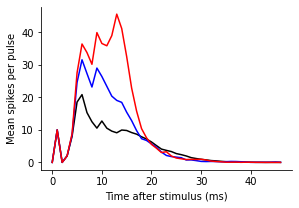

In [9]:
fig, ax = plt.subplots(figsize=(4.5,3))
for cond, hists in histograms.items():
    pspike = hists['pspike'].sum(0)[:tmax]
    ax.plot(time/ms, pspike, c=pu.colors[cond], label=cond)
plt.xlabel('Time after stimulus (ms)')
plt.ylabel('Mean spikes per pulse')
sns.despine()

# TODO: Inset with DD/SSA index across nets
# NOTE: Ensure same template in Fig2

# C: Most neurons fire 0-1 spikes

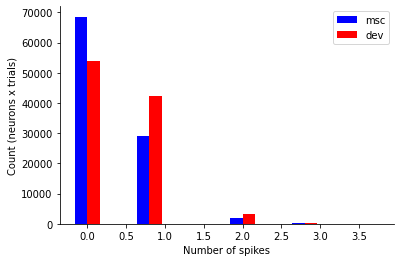

In [10]:
plt.hist([nspikes[cond].flatten() for cond in nonstandard], color=[pu.colors[cond] for cond in nonstandard], label=nonstandard,
         align='left')
plt.legend()
plt.xlabel('Number of spikes')
plt.ylabel('Count (neurons x trials)')
sns.despine()

# D: Deviant thresholds are lower

In [11]:
pdiff = histograms['dev']['pspike'] - histograms['msc']['pspike']
psign_contrast = {}
masks = (pdiff > 0.05, pdiff < -0.05)
for measure in voltage_measures:
    contrast = histograms['dev'][measure] - histograms['msc'][measure]
    contrast = np.stack([contrast * np.where(mask, 1, np.nan) for mask in masks])
    psign_contrast[measure] = contrast

(<Figure size 720x576 with 3 Axes>,
 array([<AxesSubplot:xlabel='Time after pulse onset (ms)', ylabel='Neuron #'>,
        <AxesSubplot:xlabel='Time after pulse onset (ms)'>], dtype=object),
 <matplotlib.colorbar.Colorbar at 0x7fcfad613fd0>)

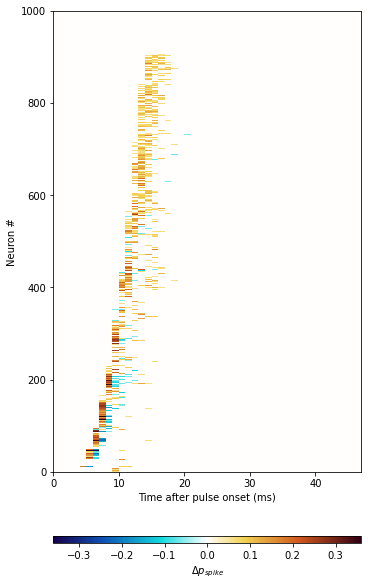

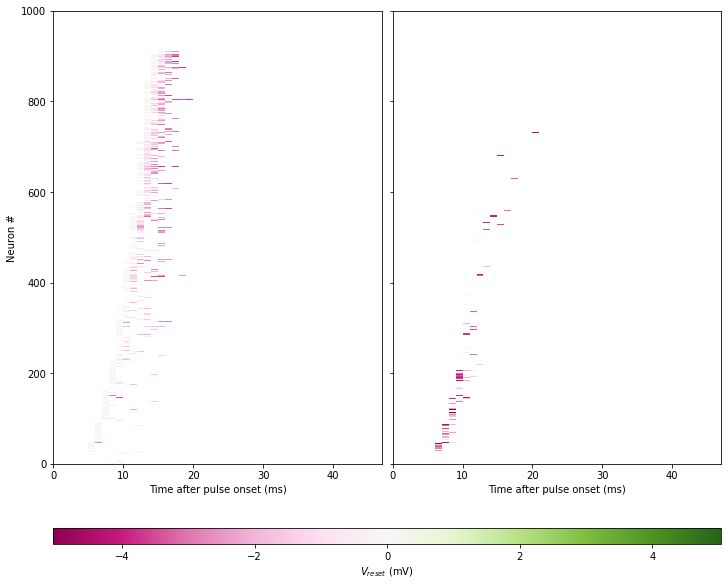

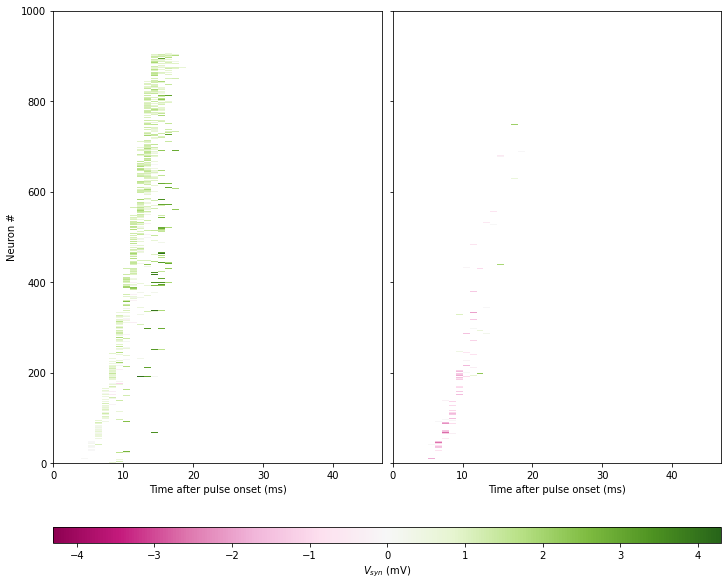

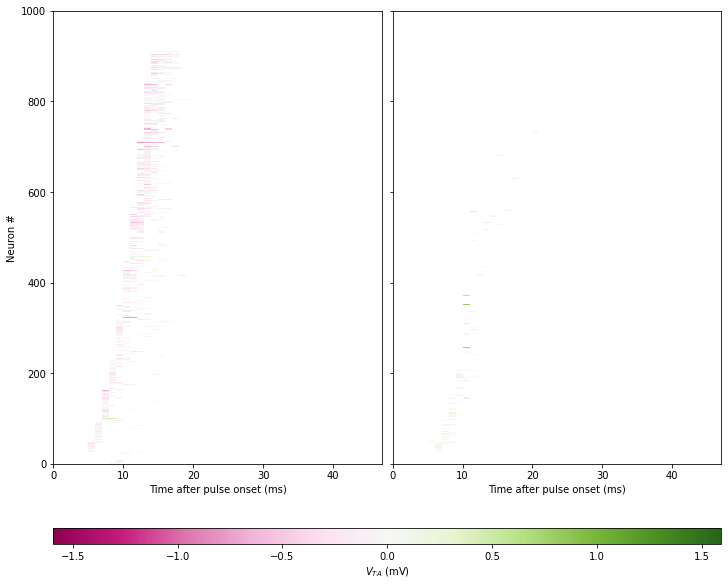

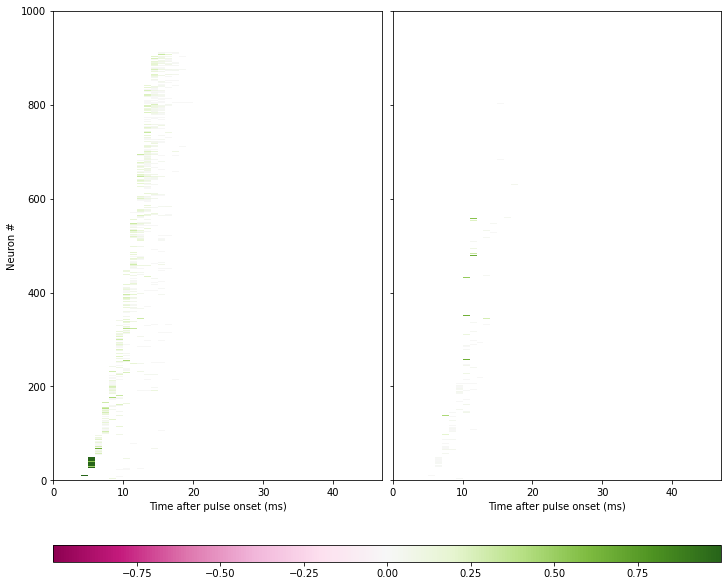

In [12]:
fig, axs, cb = pu.plot_pulse_hist([np.where(sum(masks), pdiff, 0)], index_N, index_t, cfg.params['dt'], figsize=(5,8), cmap=pu.ccc_divergent)
cb.set_label('$\\Delta p_{spike}$')

for measure, contrast in psign_contrast.items():
    fig, axs, cb = pu.plot_pulse_hist(contrast/mV, index_N, index_t, cfg.params['dt'], figsize=(10,8))
    cb.set_label(labelling[measure])

pu.plot_pulse_hist(np.abs(psign_contrast['Threshold']) / sum(np.abs(contrast) for contrast in psign_contrast.values()), index_N, index_t, cfg.params['dt'], figsize=(10,8))

WARNING    /home/felix/projects/culture/.env/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
 [py.warnings]


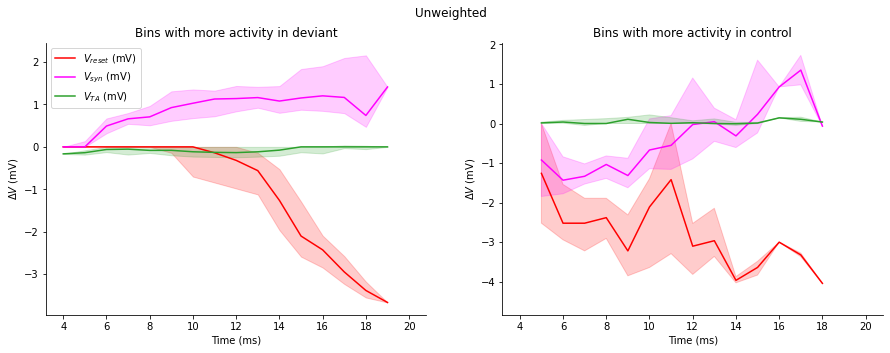

In [13]:
fig, axs = plt.subplots(1,2, figsize=(15,5), sharex=True)
time = np.arange(tmax) * cfg.params['dt'] / msecond
axs[0].set_title('Bins with more activity in deviant')
axs[1].set_title('Bins with more activity in control')
plt.suptitle('Unweighted')
for measure, contrast in psign_contrast.items():
    for i, ax in enumerate(axs):
        q = np.nanquantile((contrast[i])[:, :tmax]/mV, quarters, 0)
        ax.fill_between(time, q[0], q[2], color=pu.colors[measure], alpha=.2)
        ax.plot(time, q[1], color=pu.colors[measure], label=labelling[measure])
for ax in axs:
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('$\\Delta V$ (mV)')
axs[0].legend()
sns.despine()

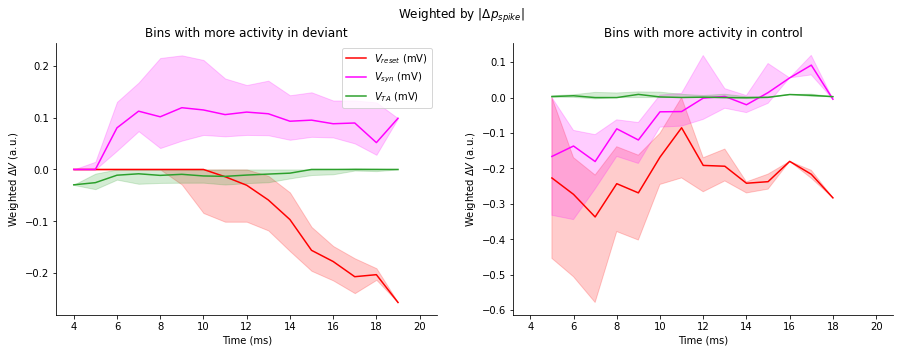

In [14]:
fig, axs = plt.subplots(1,2, figsize=(15,5), sharex=True)
time = np.arange(tmax) * cfg.params['dt'] / msecond
axs[0].set_title('Bins with more activity in deviant')
axs[1].set_title('Bins with more activity in control')
plt.suptitle('Weighted by $|\\Delta p_{spike}|$')
for measure, contrast in psign_contrast.items():
    for i, ax in enumerate(axs):
        q = np.nanquantile((contrast[i]*np.abs(pdiff))[:, :tmax]/mV, quarters, 0)
        ax.fill_between(time, q[0], q[2], color=pu.colors[measure], alpha=.2)
        ax.plot(time, q[1], color=pu.colors[measure], label=labelling[measure])
for ax in axs:
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Weighted $\\Delta V$ (a.u.)')
axs[0].legend()
sns.despine()

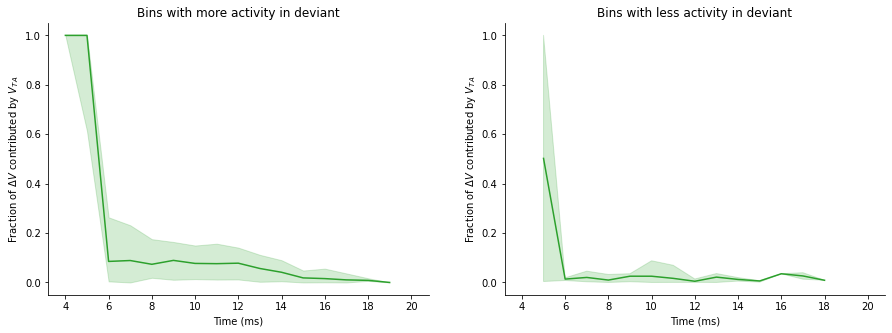

In [15]:
fig, axs = plt.subplots(1,2, figsize=(15,5), sharex=True)
axs[0].set_title('Bins with more activity in deviant')
axs[1].set_title('Bins with less activity in deviant')
for i, ax in enumerate(axs):
    ratio = np.abs(psign_contrast['Threshold'][i]) / sum([np.abs(contrast[i]) for contrast in psign_contrast.values()])
    q = np.nanquantile((ratio)[:, :tmax], quarters, 0)
    ax.fill_between(time, q[0], q[2], alpha=.2, color=pu.colors['Threshold'])
    ax.plot(time, q[1], color=pu.colors['Threshold'])
for ax in axs:
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Fraction of $\\Delta V$ contributed by $V_{TA}$')
sns.despine()